# Road Obstructions

The dataset I chose to analyze is the 311 calls dataset which includes reports of street obstructions and potholes, which would be necessary to avoid for a quality racing experience.

As always, lets import all modules for data analysis.

In [13]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas

The 311 data is available as a `.csv` on the WPRDC website, so we can dowload it and convert it into a `pandas.DataFrame` using the following code:

In [2]:
# three11_data = pd.read_csv("https://data.wprdc.org/datastore/dump/76fda9d0-69be-4dd5-8108-0de7907fc5a4")
#Alternate command
three11_data = pd.read_csv('76fda9d0-69be-4dd5-8108-0de7907fc5a4.csv')

Next we can filter the 311 dataset into just street obstruction, potholes, and other road issues. We then call `.sample()` in order to verify that our code worked.

In [8]:
road_obstructions = three11_data[(three11_data.REQUEST_TYPE == "Street Obstruction/Closure")|(three11_data.REQUEST_TYPE == "Potholes")|(three11_data.REQUEST_TYPE == "Road")]
road_obstructions.sample(10)

,REQUEST_ID,CREATED_ON,REQUEST_TYPE,REQUEST_ORIGIN,STATUS,DEPARTMENT,NEIGHBORHOOD,COUNCIL_DISTRICT,WARD,TRACT,PUBLIC_WORKS_DIVISION,PLI_DIVISION,POLICE_ZONE,FIRE_ZONE,X,Y,GEO_ACCURACY
151780,57726.0,2016-03-28T13:16:00,Potholes,Call Center,1,DPW - Street Maintenance,Central Lawrenceville,7.0,9.0,4.200309e+10,2.0,9.0,2.0,3-3,-79.956580,40.467562,EXACT
510873,528654.0,2021-06-01T08:28:00,Potholes,Website,1,DPW - Street Maintenance,Garfield,9.0,10.0,4.200310e+10,2.0,10.0,5.0,3-4,-79.944289,40.471018,EXACT
247592,259887.0,2018-06-15T13:22:00,Potholes,Call Center,3,DPW - Street Maintenance,Upper Lawrenceville,7.0,10.0,4.200310e+10,2.0,10.0,2.0,3-5,-79.949741,40.484527,EXACT
96410,126512.0,2017-01-20T11:51:00,Potholes,Website,1,DPW - Street Maintenance,Lower Lawrenceville,7.0,6.0,4.200309e+10,2.0,6.0,2.0,3-3,-79.966906,40.471717,EXACT
137775,79238.0,2016-06-15T12:15:00,Potholes,Call Center,1,DPW - Street Maintenance,Central Northside,1.0,25.0,4.200322e+10,1.0,25.0,1.0,1-6,-80.005883,40.457543,EXACT
257921,270745.0,2018-07-16T12:13:00,Potholes,Website,1,DPW - Street Maintenance,East Carnegie,2.0,28.0,4.200356e+10,5.0,28.0,6.0,1-19,-80.074023,40.417891,EXACT
200591,212743.0,2018-01-25T08:05:00,Potholes,Call Center,1,DPW - Street Maintenance,Brookline,4.0,32.0,4.200332e+10,5.0,32.0,6.0,4-26,-80.011257,40.393181,EXACT
176923,21885.0,2015-09-01T10:11:00,Potholes,Call Center,1,DPW - Street Maintenance,Point Breeze,8.0,14.0,4.200314e+10,3.0,14.0,4.0,2-17,-79.920731,40.449782,EXACT
503512,521289.0,2021-05-06T13:00:00,Street Obstruction/Closure,Call Center,1,DOMI - Permits,Bloomfield,7.0,8.0,4.200308e+10,2.0,8.0,5.0,3-6,-79.948472,40.461209,EXACT
77287,145041.0,2017-04-12T12:55:00,Potholes,Call Center,1,DPW - Street Maintenance,Brookline,4.0,19.0,4.200319e+10,5.0,19.0,6.0,4-26,-80.017344,40.404718,EXACT


The 311 dataset contains a lot of extraneous data that we do not need for now, so we can create a `Series` that has each neighborhood and its total number of road obstructions. The `value_counts()` method will automatically create this for us.

In [14]:
num_ro = road_obstructions['NEIGHBORHOOD'].value_counts()
num_ro.head()

Brookline                3782
Squirrel Hill South      2762
Bloomfield               2667
Carrick                  2593
Central Lawrenceville    1802
Name: NEIGHBORHOOD, dtype: int64

Now, let's take a look at neighborhoods with the most and least number of road obstructions:

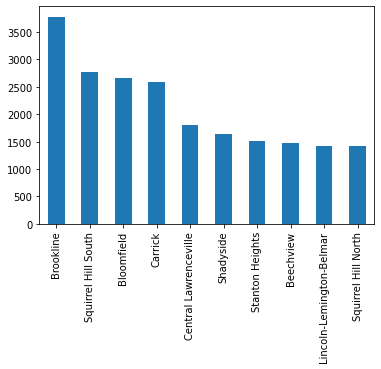

In [64]:
num_ro.head(10).plot.bar()

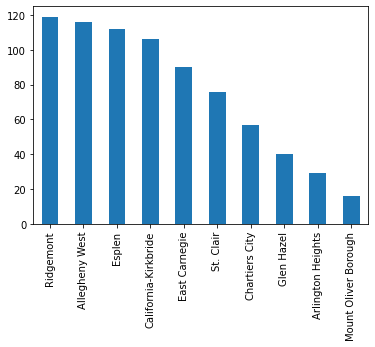

In [25]:
num_ro.tail(10).plot.bar()

Now, we can plot the number of potholes onto a map. To do this, we use `geopandas` and `Neighborhoods_.shp` which contains map data for each neighborhood in Pittsburgh.

In [15]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")

Now we can `merge` our `num_ro` dataset with our `neighborhoods` GeoDataFrame, which will give us a map with each count of road obstructions mapped on each neighborghood of Pittsburgh.

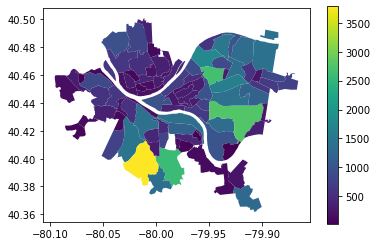

In [16]:
pm = pd.DataFrame({'neighborhood': num_ro.axes[0], 'obs': num_ro.values})
ro_map = neighborhoods.merge(pm, how='left', left_on='hood', right_on='neighborhood')
ro_map.plot(column='obs',legend=True)

Looking at the map, we can notice a problem with this: the larger neighborhoods almost universally have more potholes than smaller ones.

To account for this, we can calculate the density of road obstructions. Fortunately, the `Neighborhoods_.shp` file contains the area of each neighborhood, measured in square miles. We can add a new column to the `ro_map` dataframe with the density of road obstructions, which we can calculate as such:

In [17]:
ipsm = []

for index, row in ro_map.iterrows():
    ipsm.append(row["obs"] / row["sqmiles"])

ro_map["incident_density"] = ipsm

With our new data, let's plot the density of street obstructions on the map.

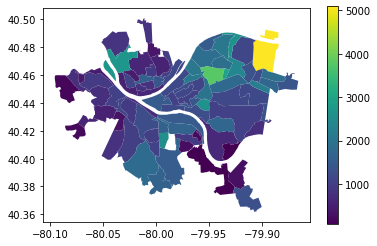

In [105]:
ro_map.plot(column='incident_density',legend=True)

This plot makes much more sense, we can see that there are more potholes in the north-east neighborhoods, now let's look at which neighborhoods have the most and least potholes, sorted by density.

In [22]:
ro_map.filter(['neighborhood', 'incident_density']).sort_values('incident_density', ascending=False).head(10)

,neighborhood,incident_density
19,Lincoln-Lemington-Belmar,5096.428571
31,Bloomfield,3799.145299
48,Friendship,2962.264151
70,Marshall-Shadeland,2722.943723
42,Morningside,2625.654450
0,Central Oakland,2622.775801
57,Knoxville,2579.470199
77,East Liberty,2380.378657
69,Point Breeze North,2188.811189
61,Polish Hill,2105.882353


Over the course of the last 6 years, Lincoln-Lemington-Belmar has had an incredible 5000 potholes per square mile! I actually can personally relate because I used to drive on Lincoln Ave on the way to school.

I went back to Google Maps to take a look at the roads:

![1](https://i.imgur.com/T864ZF9.jpg)
![2](https://i.imgur.com/8vXdaaC.jpg)

Probably wasn't the best for the suspension on my Nissan. As of 2022, both of these roads have ben paved since these images were taken.

## Best Roads
Now we can sort our neighborhoods by which one have the least amount of potholes and road obstructions (by density)

In [23]:
ro_map.filter(['neighborhood', 'incident_density']).sort_values('incident_density', ascending=True).head(10)

,neighborhood,incident_density
68,Hays,82.285714
88,Glen Hazel,87.719298
83,Fairywood,173.374613
78,East Carnegie,208.333333
63,Arlington Heights,219.696970
50,St. Clair,245.161290
79,New Homestead,292.191436
85,Ridgemont,322.493225
9,Northview Heights,383.386581
84,Chartiers City,431.818182
